# Tracing for Different types of Runs

## Types of Runs
LangSmith supports many different types of Runs - you can specify what type your Run is in the @traceable decorator. The types of runs are:  

* LLM: Invokes an LLM  
* Retriever: Retrieves documents from databases or other sources  
* Tool: Executes actions with function calls  
* Chain: Default type; combines multiple Runs into a larger process  
* Prompt: Hydrates a prompt to be used with an LLM  
* Parser: Extracts structured data  

### Set up

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### LLM Runs for chat models
LangSmith offers enhanced rendering for LLM traces when logged in the correct format.  

For chat-style models, inputs must be a list of messages in OpenAI-compatible format (Python dictionaries/TypeScript objects.) Each message must contain the key role and content.  

The output is accepted in any of the following formats:  

* A dictionary/object that contains the key choices with a value that is a list of dictionaries/objects. Each dictionary/object must contain the key message, which maps to a message object with the keys role and content.  
* A dictionary/object that contains the key message with a value that is a message object with the keys role and content.
* A tuple/array of two elements, where the first element is the role and the second element is the content.  
* A dictionary/object that contains the key role and content. The input to your function should be named messages.  4

You can also provide the following metadata fields to help LangSmith identify the model and calculate costs. (If using LangChain or OpenAI wrapper, these fields will be automatically populated correctly.)  

ls_provider: The provider of the model, eg "openai", "anthropic", etc.  
ls_model_name: The name of the model, eg "gpt-4o-mini", "claude-3-opus-20240307", etc.  

In [9]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = {
  "choices": [
      {
          "message": {
              "role": "assistant",
              "content": "Sure, what time would you like to book the table for?"
          }
      }
  ]
}

# Can also use one of:
# output = {
#     "message": {
#         "role": "assistant",
#         "content": "Sure, what time would you like to book the table for?"
#     }
# }
#
# output = {
#     "role": "assistant",
#     "content": "Sure, what time would you like to book the table for?"
# }
#
# output = ["assistant", "Sure, what time would you like to book the table for?"]

@traceable(
  # Added an run_type="llm", and metadata for ls_provider, and ls_model_name
  run_type="llm",
  metadata={
    "ls_provider": "openai",
    "ls_model_name": "gpt-4.1-nano"
  }
)
def chat_model(messages: list):
  return output

chat_model(inputs)

{'choices': [{'message': {'role': 'assistant',
    'content': 'Sure, what time would you like to book the table for?'}}]}

In [ ]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a prankster who has appropriate jokes for everything"},
  {"role": "user", "content": "How much does a roof cost"},
]

output = {
    "role" : "prankster",
    "content" : "Nothing! It's on the house"
}

@traceable(
        run_type="llm",
        metadata={
    "ls_provider": "openai",
    "ls_model_name": "gpt-4.1-nano"
        }
)
def chat_model(messages: list):
    return output

chat_model(input)

{'role': 'prankster', 'content': "Nothing! It's on the house"}

### Handling Streaming LLM Runs

For streaming, reduce outputs to match non-streaming format. Currently Python-supported onyl.

In [16]:
def _reduce_chunks(chunks: list):
    all_text = "".join([chunk["choices"][0]["message"]["content"] for chunk in chunks])
    return {"choices": [{"message": {"content": all_text, "role": "assistant"}}]}

@traceable(
    run_type="llm",
    metadata={"ls_provider": "my_provider", "ls_model_name": "my_model"},
    #Adding a reduce_fn
    
    reduce_fn=_reduce_chunks
)
def my_streaming_chat_model(messages: list):
    for chunk in ["Hello, " + messages[1]["content"] + ". How has your day been so far?"]:
        yield {
            "choices": [
                {
                    "message": {
                        "content": chunk,
                        "role": "assistant",
                    }
                }
            ]
        }

list(
    my_streaming_chat_model(
        [
            {"role": "system", "content": "You are a helpful assistant. Please greet the user."},
            {"role": "user", "content": "Viraja"},
        ],
    )
)

[{'choices': [{'message': {'content': 'Hello, Viraja. How has your day been so far?',
     'role': 'assistant'}}]}]

### 

### Retriever Runs + Documents

Many LLM applications require looking up documents from vector databases, knowledge graphs, or other types of indexes. Retriever traces are a way to log the documents that are retrieved by the retriever. LangSmith provides special rendering for retrieval steps in traces to make it easier to understand and diagnose retrieval issues. In order for retrieval steps to be rendered correctly, a few small steps need to be taken:  

1.Annotate with run_type="retriever"  
2.Return a list of dicts/objects, each containing:  
* page_content: Document text
* type: Always set to "Document"
* metadata: Dict/object with document metadata (displayed in trace)

In [20]:
from langsmith import traceable

def _convert_docs(results):
  return [
      {
          "page_content": r,
          "type": "Document", # This is the correct format! The key should be type and not doc_type
          "metadata": {"md1": "md2"}
      }
      for r in results
  ]

@traceable(
    # Added an run_type="retriever"
    run_type= "retriever"
)
def retrieve_docs(query):
  # Retriever returning hardcoded dummy documents.
  # In production, this could be a real vector datatabase or other document index.
  contents = ["Document contents 1", "Document contents 2", "Document contents 3"]
  return _convert_docs(contents)

retrieve_docs("User query")

[{'page_content': 'Document contents 1',
  'type': 'Document',
  'metadata': {'md1': 'md2'}},
 {'page_content': 'Document contents 2',
  'type': 'Document',
  'metadata': {'md1': 'md2'}},
 {'page_content': 'Document contents 3',
  'type': 'Document',
  'metadata': {'md1': 'md2'}}]

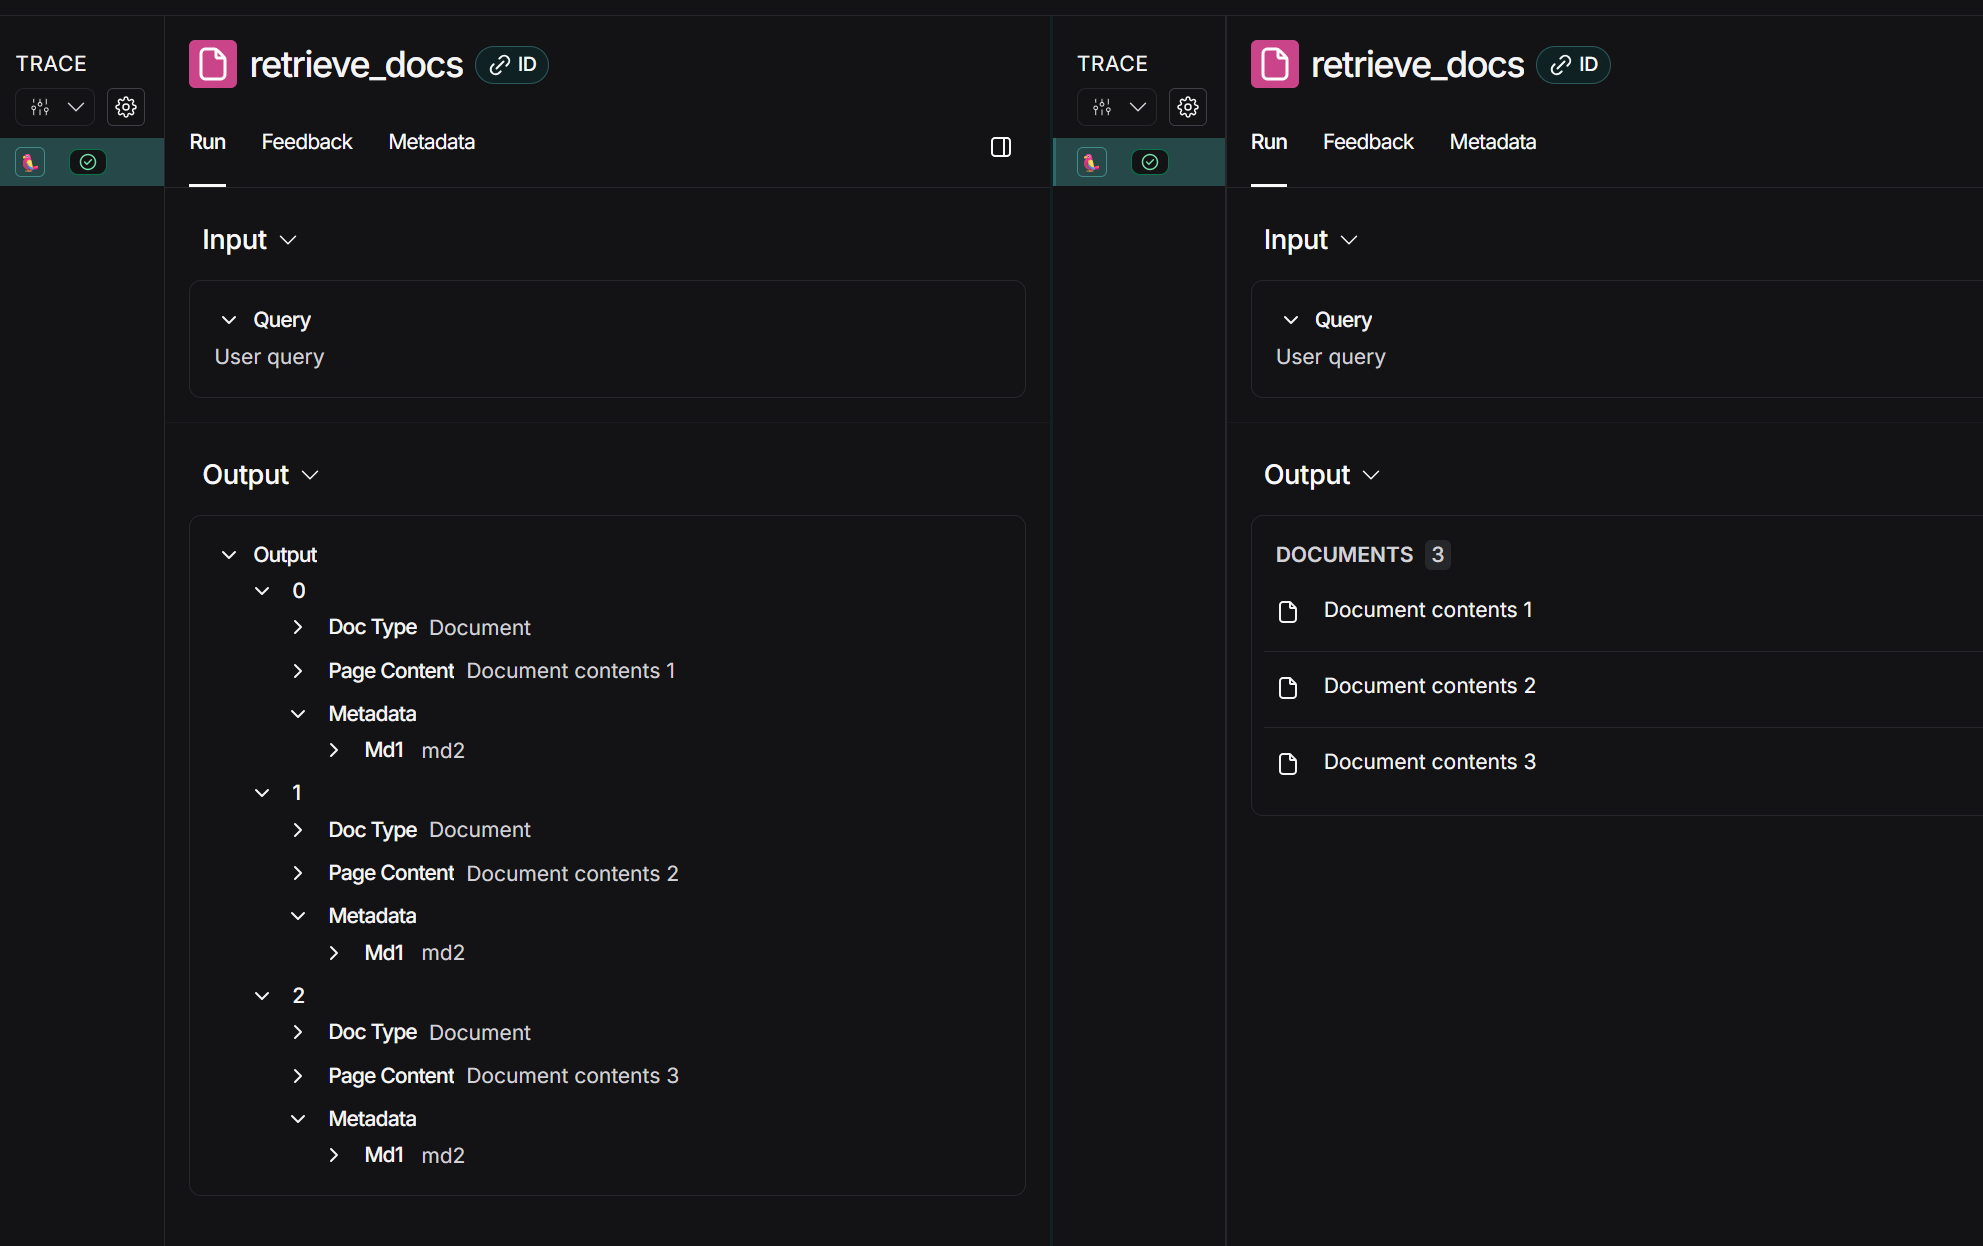

### Tool Calling

LangSmith has custom rendering for Tool Calls made by the model to make it clear when provided tools are being used.


In [21]:
from langsmith import traceable
from openai import OpenAI
from typing import List, Optional
import json

openai_client = OpenAI()

@traceable(
  # Added an run_type="tool"
  run_type= "tool"

)
def get_current_temperature(location: str, unit: str):
    return 65 if unit == "Fahrenheit" else 17

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], tools: Optional[List[dict]]
) -> str:
  return openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=0,
    tools=tools
  )

@traceable(run_type="chain")
def ask_about_the_weather(inputs, tools):
  response = call_openai(inputs, tools)
  tool_call_args = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
  location = tool_call_args["location"]
  unit = tool_call_args["unit"]
  tool_response_message = {
    "role": "tool",
    "content": json.dumps({
        "location": location,
        "unit": unit,
        "temperature": get_current_temperature(location, unit),
    }),
    "tool_call_id": response.choices[0].message.tool_calls[0].id
  }
  inputs.append(response.choices[0].message)
  inputs.append(tool_response_message)
  output = call_openai(inputs, None)
  return output

tools = [
    {
      "type": "function",
      "function": {
        "name": "get_current_temperature",
        "description": "Get the current temperature for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            },
            "unit": {
              "type": "string",
              "enum": ["Celsius", "Fahrenheit"],
              "description": "The temperature unit to use. Infer this from the user's location."
            }
          },
          "required": ["location", "unit"]
        }
      }
    }
]
inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "What is the weather today in Dadri NCR?"},
]

ask_about_the_weather(inputs, tools)

ChatCompletion(id='chatcmpl-CMtDTPJCmArISR2M8tsKWEZJ3o6OR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The current temperature in Dadri, NCR is 17°C. If you need more specific weather details like humidity, wind speed, or forecasts, please let me know!', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1759571503, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_51db84afab', usage=CompletionUsage(completion_tokens=34, prompt_tokens=81, total_tokens=115, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))